In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
hbar = 1.05457182e-34
k_b = 1.380649e-23 #m^2 kg/s^2/K
v_f = 1e6
dos_slope = 2/pi/hbar**2/v_f**2
m_e = 9.1093837e-31
R = 6e-8
pairs = []

print("Generating pairs")
N_max = 200
for i in tqdm(range(1,N_max)):
    for j in range(i+1):
        pairs.append((i,j))

print("Evaluating pairs")
vals = [p[0]**2 + p[1]**2 for p in tqdm(pairs)]
ordered = list(zip(vals, pairs))
ordered.sort()
ordered = np.array(ordered[:6000]) # take the first 6000 energy levels

Generating pairs


100%|██████████| 199/199 [00:00<?, ?it/s]


Evaluating pairs


100%|██████████| 20099/20099 [00:00<00:00, 633325.44it/s]
C:\Users\sfska\AppData\Local\Temp\ipykernel_15652\1029499567.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ordered = np.array(ordered[:6000]) # take the first 6000 energy levels


100%|██████████| 6000/6000 [00:00<00:00, 383029.80it/s]


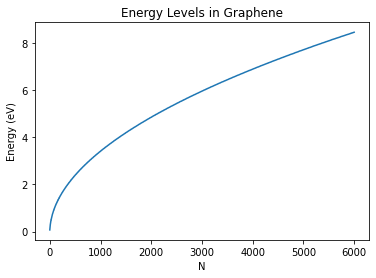

In [5]:
%matplotlib inline
plt.plot([2*pi*hbar*v_f/R*sqrt(o)/1.6e-19 for o in tqdm(ordered[:,0])])
plt.title("Energy Levels in Graphene")
plt.xlabel("N")
plt.ylabel("Energy (eV)")
plt.savefig("graphs/energy levels in graphene")
plt.show()

Building bessel function lookup table


100%|██████████| 200/200 [00:01<00:00, 138.28it/s]


Evaluating pairs for analytic solution


100%|██████████| 6000/6000 [00:00<00:00, 383321.51it/s]


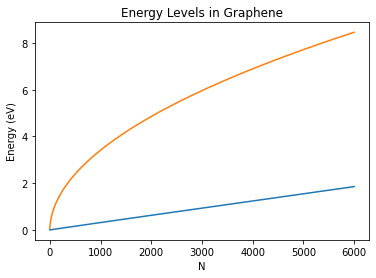

In [9]:
from scipy.special import jn_zeros

print("Building bessel function lookup table")
js = [jn_zeros(i, 200) for i in tqdm(range(200))]
print("Evaluating pairs for analytic solution")
energies = []
for n, l in tqdm(pairs):
    energies.append(hbar**2/2/m_e/R**2/1.6e-19 * js[l-1][n]**2)

energies.sort()

plt.plot(energies[:6000])
plt.plot([2*pi*hbar*v_f/R*sqrt(o)/1.6e-19 for o in tqdm(ordered[:,0])])
plt.title("Energy Levels in Graphene")
plt.xlabel("N")
plt.ylabel("Energy (eV)")
plt.show()